# Over-Representation Analysis

Notebook for performing an over-representation analysis on the top and bottom strains, in terms of redness and normalized redness.

2020-02-26

## Initial boilerplate

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = ''
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

Standard variables loaded, you are good to go!


## 1. Load data

We will use:
* 4 lists (generated manually):
  * Top 500 genes in terms of redness, with size $\geq$ 180 and count > 1.
  * Top 500 genes in terms of normalized redness, with size $\geq$ 260.
  * Bottom 500 genes in terms of redness, with size $\geq$ 180 and count > 1.
  * Bottom 500 genes in terms of normalized redness, with size $\geq$ 180 and count > 1.
* The lookup table connecting positions in the 384-well plate to gene ids, as it has all GO-terms associated to each gene ID.

In [2]:
import pandas as pd

data = pd.read_csv(join(INTERMEDIATE,"top_and_bottom_500.csv"))
print(data)

    top_redness top_norm_redness bottom_redness bottom_norm_redness
0          CSE2             GAS5          IBA57                OPY1
1          MLC2             YOR1           OPY1                RIM8
2          YOR1          YJL175W        YCR090C               IBA57
3          NTA1             SKY1           HTD2                BUD8
4       YOL153C          YIL096C           DIA3               RPL9A
..          ...              ...            ...                 ...
495        PTK1             TRP1          SPO74                RTC2
496     YBR287W          YPR071W        YDL211C                IPK1
497        PLB2             BPT1           YCH1             YMR160W
498        TRP1             NEJ1           YSP2                STP2
499     YKR070W             REX3        YIL012W             YGL152C

[500 rows x 4 columns]


In [3]:
gene_ids = pd.read_csv(join(RAW_EXTERNAL,"geneIDs.txt"), sep="\t")
gene_ids = gene_ids[gene_ids["Gene"] != "Blank"]  # filter out blank data
gene_ids = gene_ids.drop(columns=["Plate #", "Row", "Column", "96-position"])  # remove unused columns
gene_ids.index = range(0,len(gene_ids.index))  # re-index for consistency later on
print(gene_ids)

            ORF       Gene                                         Decription  \
0       YLL040C      VPS13  Protein of unknown function; heterooligomeric ...   
1       YAL068C       PAU8  Protein of unknown function, member of the ser...   
2       YAL067C       SEO1  Putative permease, member of the allantoate tr...   
3       YLL041C       SDH2  Iron-sulfur protein subunit of succinate dehyd...   
4       YAL066W    YAL066W  Dubious open reading frame unlikely to encode ...   
...         ...        ...                                                ...   
4842    YER122C       GLO3  ADP-ribosylation factor GTPase activating prot...   
4843    YJL075C      APQ13  Dubious open reading frame, unlikely to encode...   
4844    YBR035C       PDX3  Pyridoxine (pyridoxamine) phosphate oxidase, h...   
4845    YPR072W       NOT5  Subunit of the CCR4-NOT complex, which is a gl...   
4846  YOR008C-A  YOR008C-A  Putative protein of unknown function, includes...   

                           

## 2. GO terms

We will first collect all GO terms in a single list, to be able to iterate through later.

In [4]:
GOterms = []
for (idx, row) in gene_ids.iterrows():
    row["GO Biological Process"] = row["GO Biological Process"].split(", ")
    GOterms.extend(row["GO Biological Process"])
GOterms = list(set(GOterms))
GOterms.sort()
print(GOterms)
GOterms.remove('-')

['-', 'DNA metabolic process', 'RNA metabolic process', 'biological_process', 'cell budding', 'cell cycle', 'cellular amino acid and derivative metabolic process', 'cellular aromatic compound metabolic process', 'cellular carbohydrate metabolic process', 'cellular component morphogenesis', 'cellular homeostasis', 'cellular lipid metabolic process', 'cellular membrane organization', 'cellular protein catabolic process', 'cellular respiration', 'chromosome organization', 'chromosome segregation', 'cofactor metabolic process', 'conjugation', 'cytokinesis', 'cytoskeleton organization', 'fungal-type cell wall organization', 'generation of precursor metabolites and energy', 'heterocycle metabolic process', 'meiosis', 'mitochondrion organization', 'nucleus organization', 'other', 'peroxisome organization', 'protein complex biogenesis', 'protein folding', 'protein modification process', 'pseudohyphal growth', 'response to chemical stimulus', 'response to stress', 'ribosome biogenesis', 'signal

## 3. Over-Representation Analysis

We need a function for the over-representation analysis. For each GO term the Fisher matrix is constructed as:

|   | Selected in group | Not selected |
|:-:|:-----------------:|:------------:|
| With GO term | F[0][0] | F[0][1] |
| Without GO term | F[1][0] | F[1][1] |

And then the alternative hypothesis is that there is a higher percentage of genes in the selected group with the GO term Vs without the GO term.

In [5]:
from fisher import pvalue

# over-representation function:
def over_rep(data, group_name, gene_ids, GOterms):
    pvalues = pd.DataFrame()
    group = list(data[group_name])
    for GOterm in GOterms:
        F = [[0, 0], [0, 0]]
        for (idx, row) in gene_ids.iterrows():
            i = 0 if GOterm in row["GO Biological Process"] else 1
            j = 0 if row["Gene"] in group else 1
            F[i][j] += 1
        pval = pvalue(F[0][0], F[0][1], F[1][0], F[1][1]).right_tail
        new_row = pd.DataFrame(data={"genes.selected":F[0][0], "genes.total":F[0][0] + F[0][1], "p.value": pval}, index=[GOterm])
        pvalues = pvalues.append(new_row)
    print(pvalues[pvalues["p.value"] < 0.05])
    return pvalues

Now we can call the function for all 4 groups:

In [6]:
p_values_top_redness = over_rep(data, "top_redness", gene_ids, GOterms)

Empty DataFrame
Columns: [genes.selected, genes.total, p.value]
Index: []


In [7]:
p_values_top_norm_redness = over_rep(data, "top_norm_redness", gene_ids, GOterms)

                    genes.selected  genes.total   p.value
biological_process             173         1405  0.004948


In [8]:
p_values_bottom_redness = over_rep(data, "bottom_redness", gene_ids, GOterms)

                              genes.selected  genes.total   p.value
protein modification process              56          410  0.026396


In [9]:
p_values_bottom_norm_redness = over_rep(data, "bottom_norm_redness", gene_ids, GOterms)

                           genes.selected  genes.total   p.value
vitamin metabolic process               9           46  0.049671


Results don't look very promising... most likely because there are not many GO terms included in the original file.

## 4. Using GOATOOLS

Let's try using more GO terms, via GOATOOLS. For that, we first need Entrez IDs for all genes both from the total list of _S. cerevisiae_ genes and from the 4 selected groups. We can get them using the `mygene` package ([Wu et al. 2014](https://www.biorxiv.org/content/10.1101/009332v1)), querying the original ORFs:

In [10]:
import mygene
mg = mygene.MyGeneInfo()
geneORFs = list(gene_ids["ORF"])
entrezIDs = mg.querymany(geneORFs, scopes='locus_tag', fields='entrezgene', species=559292)  # S. cerevisiae S288C
entrezIDs[:10]

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4847...done.
Finished.
45 input query terms found dup hits:
	[('YML086C', 2), ('YMR169C', 2), ('YMR174C', 2), ('YMR175W', 2), ('YML035C', 2), ('YMR191W', 2), ('Y
411 input query terms found no hit:
	['YAL066W', 'YLL047W', 'YLR123C', 'YLR124W', 'YML089C', 'YAL045C', 'YAL043C-a', 'YML084W', 'YMR151W'
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


[{'query': 'YLL040C',
  '_id': '850619',
  '_score': 13.181119,
  'entrezgene': '850619'},
 {'query': 'YAL068C',
  '_id': '851229',
  '_score': 12.909299,
  'entrezgene': '851229'},
 {'query': 'YAL067C',
  '_id': '851230',
  '_score': 13.242119,
  'entrezgene': '851230'},
 {'query': 'YLL041C',
  '_id': '850685',
  '_score': 13.257929,
  'entrezgene': '850685'},
 {'query': 'YAL066W', 'notfound': True},
 {'query': 'YLL042C',
  '_id': '850684',
  '_score': 13.2468605,
  'entrezgene': '850684'},
 {'query': 'YAL065C',
  '_id': '851232',
  '_score': 13.765591,
  'entrezgene': '851232'},
 {'query': 'YLL043W',
  '_id': '850683',
  '_score': 13.254437,
  'entrezgene': '850683'},
 {'query': 'YAL062W',
  '_id': '851237',
  '_score': 13.253534,
  'entrezgene': '851237'},
 {'query': 'YLL045C',
  '_id': '850682',
  '_score': 13.251958,
  'entrezgene': '850682'}]

Note that several entries are either duplicated or don't match to anything. Also, `entrezIDs` is in dictionary format, but we need it as a list of just `entrezgene` ids. So we will create a list with just that (that we will call `population`) and translate all genes in the selected groups:

In [11]:
population = []
gene_ids["entrez"] = ""
for (idx, row) in gene_ids.iterrows():
    gene = entrezIDs[idx]
    if "entrezgene" in gene:
        entrezID = int(gene["entrezgene"])  # convert to integer (needed for GOATOOLS)
        gene_ids["entrez"][idx] = entrezID  # add to datframe for easier access later
        population.append(entrezID)  # add to population
        data = data.replace(to_replace=row["Gene"], value=entrezID)  # replace in all selected groups
        
print(len(population))
data

4436


,top_redness,top_norm_redness,bottom_redness,bottom_norm_redness
0,855744,854127,853586,852426
1,856318,853198,852426,852837
2,853198,YJL175W,850452,853586
3,853525,855256,856464,851067
4,854012,854711,851537,852730
...,...,...,...,...
495,853635,851570,852705,852444
496,852590,856184,851315,851910
497,855018,850645,853117,855195
498,851570,850970,851926,856397


Note that not all genes are added to the selected genes, due to missing IDs, but the coverage is good enough (above 90% in all cases):

In [12]:
for col in data:
    mapped_genes = sum(map(lambda x : type(x) is int, list(data[col])))
    print(col + ": " + str(mapped_genes))

top_redness: 462
top_norm_redness: 458
bottom_redness: 461
bottom_norm_redness: 458


 So let's proceed. We now need a list of all ontologies, and a list of all associations gene/ontology. The package GOATOOLS ([Klopfenstein et al. 2019](https://doi.org/10.1038/s41598-018-28948-z)) provides that, together with improved enrichment tools (corrected p-values, additional tests, etc), so we will from here forward use that.

In [13]:
# Get ontologies (from http://geneontology.org/ontology/go-basic.obo)
from goatools.base import download_go_basic_obo, get_godag
from goatools.obo_parser import GODag
obo_fname = download_go_basic_obo()  # Download data
obodag = GODag(obo_fname)  # Load data
godag = get_godag(obo_fname, optional_attrs='relationship')  # Get ancestors

# Get associations genes <-> ontologies (from ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz)
from goatools.base import download_ncbi_associations
from goatools.anno.genetogo_reader import Gene2GoReader
gene2go_fname = download_ncbi_associations()  # Download data
objanno = Gene2GoReader(gene2go_fname, taxids=[559292])  # Read data (only for Saccharomyces cerevisiae S288C)
ns2assoc = objanno.get_ns2assc()

#Remove downloaded data:
os.remove(obo_fname)
os.remove(gene2go_fname)

requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo

go-basic.obo: fmt(1.2) rel(2020-03-23) 47,232 GO Terms
  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2020-03-23) 47,232 GO Terms; optional_attrs(relationship)
FTP RETR ftp.ncbi.nlm.nih.gov gene/DATA gene2go.gz -> gene2go.gz
  gunzip gene2go.gz
HMS:0:00:02.975079  94,086 annotations,  6,349 genes,  6,156 GOs, 1 taxids READ: gene2go 


Now we create an over-representation object, with all genes, ontologies, associations and settings included in it. This object will be used for every single analysis to perform later on:

In [14]:
# Over-representation object:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
goeaobj = GOEnrichmentStudyNS(
    population,  # Population (all mapped yeast genes in Entrez format)
    ns2assoc,  # geneid/GO associations
    obodag,  # Ontologies
    propagate_counts = False,  # ???
    alpha = 0.05,  # default significance cut-off
    methods = ['fdr_bh'])  # default multipletest correction method


Load BP Gene Ontology Analysis ...
 88%  3,887 of  4,436 population items found in association

Load CC Gene Ontology Analysis ...
 93%  4,141 of  4,436 population items found in association

Load MF Gene Ontology Analysis ...
 75%  3,338 of  4,436 population items found in association


Using this object, we can repeat the analysis from before for all 4 groups:

In [15]:
import collections as cx

def goea(data, group_name, **kwargs):
    group = list(data[group_name])
    goea_results_all = goeaobj.run_study(group, **kwargs)
    # Print succint significant results:
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    ctr = cx.Counter([r.NS for r in goea_results_sig])
    print('Significant results with n={TOTAL}: {BP} BP + {MF} MF + {CC} CC'.format(
        TOTAL=len(group),
        BP=ctr['BP'],  # biological_process
        MF=ctr['MF'],  # molecular_function
        CC=ctr['CC'])) # cellular_component    
    # Save any uncorrected significant result:
    goea_results_sig = [r for r in goea_results_all if r.p_uncorrected < 0.05]
    goea_results_sig.sort(key=lambda x: (x.NS, x.GO))
    goeaobj.wr_tsv(join(FINAL, "p_values_" + group_name + ".tsv"), goea_results_sig)

goea(data, "top_redness")


Run BP Gene Ontology Analysis: current study set of 500 IDs ... 88%    405 of    461 study items found in association
 92%    461 of    500 study items found in population(4436)
Calculating 2,843 uncorrected p-values using fisher
   2,843 GO terms are associated with  3,845 of  4,436 population items
     902 GO terms are associated with    405 of    499 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 500 IDs ... 91%    418 of    461 study items found in association
 92%    461 of    500 study items found in population(4436)
Calculating 712 uncorrected p-values using fisher
     712 GO terms are associated with  4,099 of  4,436 population items
     238 GO terms are associated with    418 of    499 study items
  METHOD f

That's a lot of output, so let's prevent it using `prt=None` from here onwards:

In [16]:
goea(data, "top_norm_redness", prt=None)

Significant results with n=500: 0 BP + 0 MF + 0 CC
     88 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_top_norm_redness.tsv


In [17]:
goea(data, "bottom_redness", prt=None)

Significant results with n=500: 0 BP + 0 MF + 0 CC
     84 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_bottom_redness.tsv


In [18]:
goea(data, "bottom_norm_redness", prt=None)

Significant results with n=500: 0 BP + 0 MF + 0 CC
     54 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_bottom_norm_redness.tsv


As observed, no ontology shows to be significant when looking at the corrected p-values. Some ontologies do show significance if we consider only the uncorrected p-values, but then false positives are to be expected. We should probably play with the number of genes inside of each group, as maybe 500 was too many...

## 5. Changing the group size

Let's start by lowering the group to 100 genes:

In [19]:
goea(data.head(100), "top_redness", prt=None)

Significant results with n=100: 0 BP + 0 MF + 0 CC
    122 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_top_redness.tsv


In [20]:
goea(data.head(100), "top_norm_redness", prt=None)

Significant results with n=100: 0 BP + 0 MF + 0 CC
    135 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_top_norm_redness.tsv


In [21]:
goea(data.head(100), "bottom_redness", prt=None)

Significant results with n=100: 0 BP + 0 MF + 0 CC
    104 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_bottom_redness.tsv


In [22]:
goea(data.head(100), "bottom_norm_redness", prt=None)

Significant results with n=100: 0 BP + 0 MF + 0 CC
     90 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_bottom_norm_redness.tsv


Still nothing significant, although the number of uncorrected p-values below 0.05 increases for all conditions. We will vary the group size from 10 to 500 in increments of 10 to find something significant (also removing the output to keep the notebook reasonably short):

In [23]:
# Function that returns the number of significant p-values according to the fdr_bh test (without printing anything):
def goea_return_sig(data, group_name, test):
    group = list(data[group_name])
    goea_results_all = goeaobj.run_study(group, prt=None)
    if test == "fdr_bh":
        goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    elif test == "uncorrected":
        goea_results_sig = [r for r in goea_results_all if r.p_uncorrected < 0.05]
    return goea_results_sig

# Call the function in a loop that goes through all group sizes (in multiples of 10) and records the number of significant GO terms:
nsig = list()
for n in range(10, 501, 10):
    nt = len(goea_return_sig(data.head(n), "top_redness", "fdr_bh"))
    ntn = len(goea_return_sig(data.head(n), "top_norm_redness", "fdr_bh"))
    nb = len(goea_return_sig(data.head(n), "bottom_redness", "fdr_bh"))
    nbn = len(goea_return_sig(data.head(n), "bottom_norm_redness", "fdr_bh"))
    print(f"Significant results with n={n}:\t{nt}\t{ntn}\t{nb}\t{nbn}")
    nsig.append([n, nt, ntn, nb, nbn])

Significant results with n=10:	0	0	0	0
Significant results with n=20:	0	0	0	0
Significant results with n=30:	0	0	0	0
Significant results with n=40:	0	0	0	0
Significant results with n=50:	0	0	0	0
Significant results with n=60:	0	0	0	0
Significant results with n=70:	0	0	0	0
Significant results with n=80:	0	0	0	0
Significant results with n=90:	0	0	0	0
Significant results with n=100:	0	0	0	0
Significant results with n=110:	0	0	0	0
Significant results with n=120:	0	0	0	0
Significant results with n=130:	0	0	0	0
Significant results with n=140:	0	0	0	0
Significant results with n=150:	2	0	0	0
Significant results with n=160:	1	0	0	0
Significant results with n=170:	1	0	0	0
Significant results with n=180:	1	0	0	0
Significant results with n=190:	1	0	0	0
Significant results with n=200:	1	0	0	0
Significant results with n=210:	0	0	0	0
Significant results with n=220:	0	0	0	0
Significant results with n=230:	0	0	0	0
Significant results with n=240:	0	0	0	0
Significant results with n=250:	0	0	0	0
Significa

So there's actually a few group sizes in which the top redness is enriched. Let's save those results:

In [24]:
goea(data.head(150), "top_redness", prt=None)
goea(data.head(150), "top_norm_redness", prt=None)
goea(data.head(150), "bottom_redness", prt=None)
goea(data.head(150), "bottom_norm_redness", prt=None)

Significant results with n=150: 1 BP + 1 MF + 0 CC
    118 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_top_redness.tsv
Significant results with n=150: 0 BP + 0 MF + 0 CC
    108 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_top_norm_redness.tsv
Significant results with n=150: 0 BP + 0 MF + 0 CC
     89 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_bottom_redness.tsv
Significant results with n=150: 0 BP + 0 MF + 0 CC
     80 items WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\data\final\p_values_bottom_norm_redness.tsv


We can also check how the number of uncorrected p-values under 0.05 change as the group size changes:

In [25]:
nsig = list()
for n in range(10, 501, 10):
    nt = len(goea_return_sig(data.head(n), "top_redness", "uncorrected"))
    ntn = len(goea_return_sig(data.head(n), "top_norm_redness", "uncorrected"))
    nb = len(goea_return_sig(data.head(n), "bottom_redness", "uncorrected"))
    nbn = len(goea_return_sig(data.head(n), "bottom_norm_redness", "uncorrected"))
    print(f"p-val<0.05 with n={n}:\t{nt}\t{ntn}\t{nb}\t{nbn}")
    nsig.append([n, nt, ntn, nb, nbn])

p-val<0.05 with n=10:	46	44	35	41
p-val<0.05 with n=20:	65	72	67	69
p-val<0.05 with n=30:	89	92	89	82
p-val<0.05 with n=40:	114	118	79	97
p-val<0.05 with n=50:	108	109	80	106
p-val<0.05 with n=60:	119	123	87	96
p-val<0.05 with n=70:	129	121	83	89
p-val<0.05 with n=80:	143	141	98	100
p-val<0.05 with n=90:	120	123	88	81
p-val<0.05 with n=100:	122	135	104	90
p-val<0.05 with n=110:	138	148	118	104
p-val<0.05 with n=120:	100	163	125	120
p-val<0.05 with n=130:	110	107	74	81
p-val<0.05 with n=140:	112	107	77	81
p-val<0.05 with n=150:	118	108	89	80
p-val<0.05 with n=160:	116	111	92	88
p-val<0.05 with n=170:	128	124	98	91
p-val<0.05 with n=180:	130	133	115	102
p-val<0.05 with n=190:	133	145	114	103
p-val<0.05 with n=200:	132	153	113	107
p-val<0.05 with n=210:	140	157	115	111
p-val<0.05 with n=220:	148	166	114	116
p-val<0.05 with n=230:	150	170	129	127
p-val<0.05 with n=240:	159	174	142	133
p-val<0.05 with n=250:	61	66	40	34
p-val<0.05 with n=260:	49	70	49	35
p-val<0.05 with n=270:	51	63	50	31
p

Let's see it in a plot:

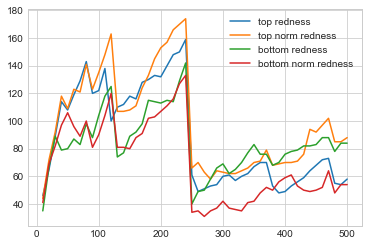

In [26]:
# Import plotting stuff:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Axis:
fig = plt.figure()
ax = plt.axes()

# Data:
line1 = ax.plot([row[0] for row in nsig], [row[1] for row in nsig], label='top redness')
line2 = ax.plot([row[0] for row in nsig], [row[2] for row in nsig], label='top norm redness')
line3 = ax.plot([row[0] for row in nsig], [row[3] for row in nsig], label='bottom redness')
line4 = ax.plot([row[0] for row in nsig], [row[4] for row in nsig], label='bottom norm redness')
ax.legend();

## 6. Analysis of Results

We will now focus on the 150 top redness group, as only that one has significant results. Let's first see the genes associated to those genes:

In [27]:
sig_results = goea_return_sig(data.head(150), "top_redness", "fdr_bh")

for GOterm in sig_results:
    print(GOterm.GO)
    for item in GOterm.study_items:        
        # Find back gene name:
        row = gene_ids.loc[gene_ids['entrez'] == item]
        geneName = row["Gene"].values[0]
        print(geneName)
    print("")

GO:0018027
SEE1
RKM1
YBR271W
NNT1

GO:0016279
NNT1
RKM1
SEE1
YNL024C
YBR271W



We can also plot the relationship:

In [28]:
from goatools.gosubdag.gosubdag import GoSubDag
from goatools.gosubdag.plot.gosubdag_plot import GoSubDagPlot

for GOterm in sig_results:
    goid = GOterm.GO
    gosubdag = GoSubDag(goid, godag, relationships=True, prt=False) # retrieve all ancestors
    file_name = goid.replace(":", "")
    GoSubDagPlot(gosubdag).plt_dag(join(FIGURES, f"{file_name}.png"))

    1 usr  23 GOs  WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\results\figures\GO0018027.png
    1 usr  11 GOs  WROTE: C:\Users\bejsab\Documents\repos\phenobooth-analysis\results\figures\GO0016279.png


Now, let's see if in these 150 top/bottom candidates there are any metabolic genes:

In [29]:
def find_metabolic(data, group_name):
    print(group_name + ":")
    for gene in list(data[group_name]):
        if gene in ns2assoc["BP"]:
            if "GO:0008152" in ns2assoc["BP"][gene]:
                row = gene_ids.loc[gene_ids['entrez'] == gene]
                geneName = row["Gene"].values[0]
                position = list(data[group_name]).index(gene)
                print(str(position+1) + ": " + geneName)
    print("")

find_metabolic(data.head(150), "top_redness")
find_metabolic(data.head(150), "bottom_redness")

top_redness:
45: UBA4
70: EPT1
85: EXG2
95: SIM1

bottom_redness:
93: HFA1



Finally, let's visualize the uncorrected p-value distribution (to observe any trends) using chord plots, as we can use the heriarchy to show relationships between GO terms. For this we first need to store the hierarchies:

In [30]:
from goatools.gosubdag.gosubdag import GoSubDag

# Function for getting all ancestors from a GO term:
def get_ancestors(goid):
    gosubdag = GoSubDag(goid, godag, prt=None)
    ancestors = list()
    for a_go in gosubdag.rcntobj.go2ancestors[goid]:
        ancestor_info = gosubdag.go2nt[a_go]._asdict()
        ancestor = {}
        ancestor["GOlvl"] = ancestor_info["level"]
        ancestor["GOterm"] = ancestor_info["GO"]
        ancestor["GOname"] = ancestor_info["GO_name"]
        ancestors.append(ancestor)
    ancestors = sorted(ancestors, key=lambda k: k['GOlvl'])
    return ancestors

# Get (uncorrected) significant GO terms:
goea_tr = goea_return_sig(data.head(150), "top_redness", "uncorrected")

# Get ancestors for all GO terms:
ancestors_tr = list()
for go in goea_tr:
    ancestors = {}
    ancestors[go.GO] = get_ancestors(go.GO)
    ancestors_tr.append(ancestors)

Using this info, we now define the nodes of the chord plot as each GO term from the analysis. Furthermore, we will define the ancestor at the 4th level (if available) as a way of grouping nodes later on:

In [31]:
# Get nodes for chord plot:
nodes = pd.DataFrame(columns=["id", "name", "group"], index=range(0,len(goea_tr)))
for (idx, GOterm) in enumerate(goea_tr):
    nodes.loc[idx,"id"] = GOterm.GO
    nodes.loc[idx,"name"] = f"{GOterm.GO} - {GOterm.name}"
    for ancestor in ancestors_tr[idx][GOterm.GO]:
        if ancestor["GOlvl"] == 4:
            nodes.loc[idx,"group"] = f"{ancestor['GOterm']} - {ancestor['GOname']}"
nodes

,id,name,group
0,GO:0018027,GO:0018027 - peptidyl-lysine dimethylation,GO:0036211 - protein modification process
1,GO:0018022,GO:0018022 - peptidyl-lysine methylation,GO:0036211 - protein modification process
2,GO:0032259,GO:0032259 - methylation,NaN
3,GO:0030950,GO:0030950 - establishment or maintenance of a...,GO:0006996 - organelle organization
4,GO:0006376,GO:0006376 - mRNA splice site selection,GO:0022607 - cellular component assembly
...,...,...,...
113,GO:0070337,GO:0070337 - 3'-flap-structured DNA binding,GO:0003677 - DNA binding
114,GO:0070338,GO:0070338 - 5'-flap-structured DNA binding,GO:0003677 - DNA binding
115,GO:0071633,GO:0071633 - dihydroceramidase activity,"GO:0016811 - hydrolase activity, acting on car..."
116,GO:0070569,GO:0070569 - uridylyltransferase activity,GO:0016779 - nucleotidyltransferase activity


We now define links between nodes as simply how many ancestors (of level 4 or higher) are shared between each GO term pair:

In [32]:
# Make a list of ancestors >= 4th level for each GOterm:
ancestor_list = []
for (idx, GOterm) in enumerate(goea_tr):
    new_list = []
    for ancestor in ancestors_tr[idx][GOterm.GO]:
        if ancestor["GOlvl"] >= 4:
            new_list.append(ancestor["GOterm"])
    ancestor_list.append(new_list)

# Get links for chord plot:
links = pd.DataFrame(columns=["source", "target", "value", "group"])
idx = 0
for (idx_s, GOterm_s) in enumerate(goea_tr):
    group = nodes["group"][idx_s]
    id_s = nodes["id"][idx_s]
    if not isinstance(group, float):  #this skips any group without a 4th level ancestor
        for (idx_t, GOterm_t) in enumerate(goea_tr):
            if idx_s != idx_t:
                n = len(list(set(ancestor_list[idx_s]) & set(ancestor_list[idx_t])))
                if n > 0:
                    id_t = nodes["id"][idx_t]
                    new_link = pd.DataFrame(data={'source': id_s, 'target': id_t, 'value': n, 'group': group}, index=[idx])
                    links = links.append(new_link)
                    idx += 1

# Sort links:
links = links.sort_values(by="group", ascending=True)
links = links.reset_index(drop=True)
links

,source,target,value,group
0,GO:0070336,GO:0070337,1,GO:0003677 - DNA binding
1,GO:0070336,GO:0070338,1,GO:0003677 - DNA binding
2,GO:0070338,GO:0070337,2,GO:0003677 - DNA binding
3,GO:0070338,GO:0070336,1,GO:0003677 - DNA binding
4,GO:0070337,GO:0070338,2,GO:0003677 - DNA binding
...,...,...,...,...
423,GO:0097510,GO:0071047,1,GO:0090304 - nucleic acid metabolic process
424,GO:0097510,GO:0006308,2,GO:0090304 - nucleic acid metabolic process
425,GO:0016071,GO:0006308,1,GO:0090304 - nucleic acid metabolic process
426,GO:0016071,GO:0002143,2,GO:0090304 - nucleic acid metabolic process


Finally, we filter out nodes with missing info and sort:

In [33]:
# Filter any groups not shown & higher level groups:
to_drop = []
for (idx, row) in nodes.iterrows():
    if (row["id"] not in list(links["source"])) and (row["id"] not in list(links["target"])):
        to_drop.append(idx)
    if isinstance(row["group"], float):
        to_drop.append(idx)
nodes = nodes.drop(to_drop)

# Sort nodes (for better display in chord plot):
nodes = nodes.sort_values(by="group", ascending=True)
nodes = nodes.reset_index(drop=True)
nodes

,id,name,group
0,GO:0070338,GO:0070338 - 5'-flap-structured DNA binding,GO:0003677 - DNA binding
1,GO:0070337,GO:0070337 - 3'-flap-structured DNA binding,GO:0003677 - DNA binding
2,GO:0070336,GO:0070336 - flap-structured DNA binding,GO:0003677 - DNA binding
3,GO:0018013,GO:0018013 - N-terminal peptidyl-glycine methy...,GO:0006479 - protein methylation
4,GO:1902475,GO:1902475 - L-alpha-amino acid transmembrane ...,GO:0006811 - ion transport
...,...,...,...
71,GO:2000765,GO:2000765 - regulation of cytoplasmic transla...,GO:0060255 - regulation of macromolecule metab...
72,GO:0015031,GO:0015031 - protein transport,GO:0071705 - nitrogen compound transport
73,GO:0016071,GO:0016071 - mRNA metabolic process,GO:0090304 - nucleic acid metabolic process
74,GO:0097510,"GO:0097510 - base-excision repair, AP site for...",GO:0090304 - nucleic acid metabolic process


The chord plot will have nodes colored based on the group they represent, and the number of connections based on the number of shared ancestors, colored by the group as well:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
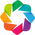

In [34]:
import param
import numpy as np
import holoviews as hv
hv.extension('bokeh', 'matplotlib')
%output backend='matplotlib' fig='svg' size=200
%output backend='bokeh' size=200

In [35]:
%%opts Chord [label_index='id' width=350 height=350]
%%opts Chord [color_index='group' edge_color_index='group']
%%opts Chord (node_color=Cycle('tab20') edge_color=Cycle('tab20'))
ds = hv.Dataset(nodes, 'id', ['name', 'group'])
hv.Chord((links, ds))

:Chord   [source,target]   (value,group)